Exploración previa del conjunto de datos para conocer las características de la serie de precios de cierre del Bitcoin. 
1. Se recolectan todos los datos en un dataframe "Data.csv" que será usado en el resto de los notebooks (cada uno utilizará las columnas que necesita).
2. Se descompone la serie de tiempo correspondiente al precio de cierre del Bitcoin, en sus componentes de tendencia, estacionalidad y ruido.
3. Se analizará la correlación entre las variables.

In [7]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
import seaborn as sns # Para plots

import statsmodels.api as sm #Descomposición 

#Manejo de archivos
import os
import tempfile
import shutil
import json

import DataManager as dm

In [8]:
# Obtener todos los datos
todas_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','tether',
                     'monero','ethereum-classic','nem','augur',                 
                     'cardano','stellar','iota','tron',
                     'neo','bitcoin-cash','eos','vechain',
                     'qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur','tether']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

targets_crypto = todas_criptomonedas
targets_stocks = stockindex_names + stocks_names
targets_trends = ['trend_'+ m for m in top_criptomonedas]

actualizar = False
if actualizar:
    crypto = dm.get_crypto(targets_crypto,fecha_comienzo='2015-01-01',fecha_fin='2018-05-25')
    stocks = dm.get_stocks(targets_stocks)
    trends = dm.get_trends(targets_trends,fecha_comienzo='2015-01-01',fecha_fin='2018-05-25')
    data = pd.merge(crypto, stocks,  how='left', left_index=True, right_index=True)
    data = pd.merge(data, trends,  how='left', left_index=True, right_index=True)
    data = data.interpolate().ffill().fillna(0) #Completar campos faltantes
    data.to_csv('data/data.csv')

data = pd.read_csv('data/data.csv' )
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#data = data[:'2018-05-25']

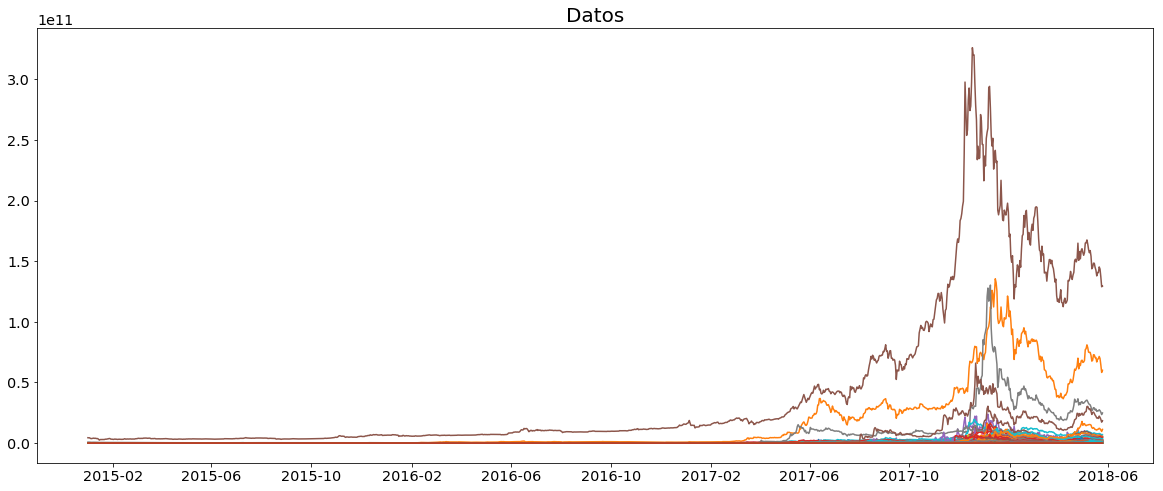

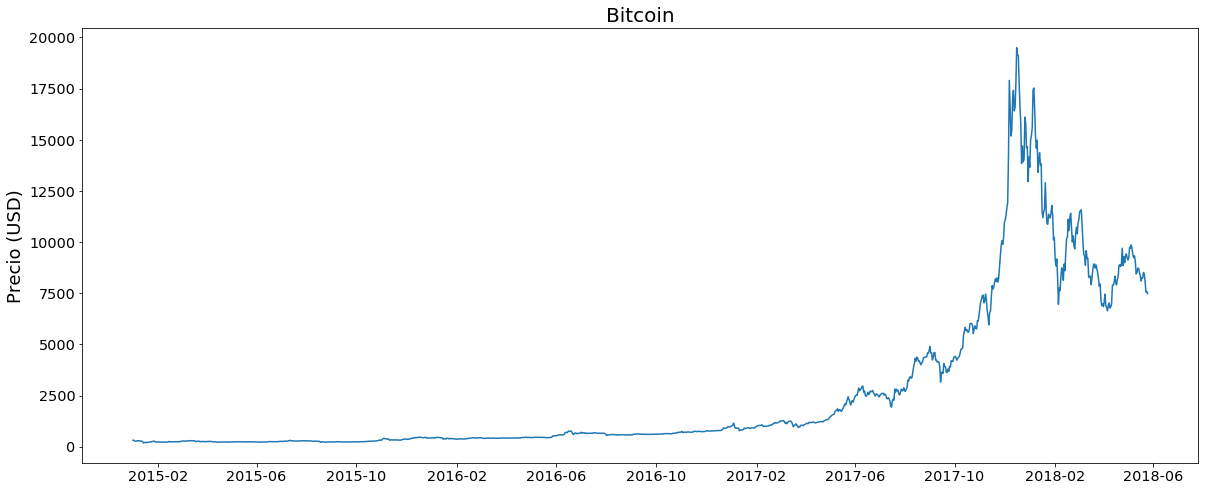

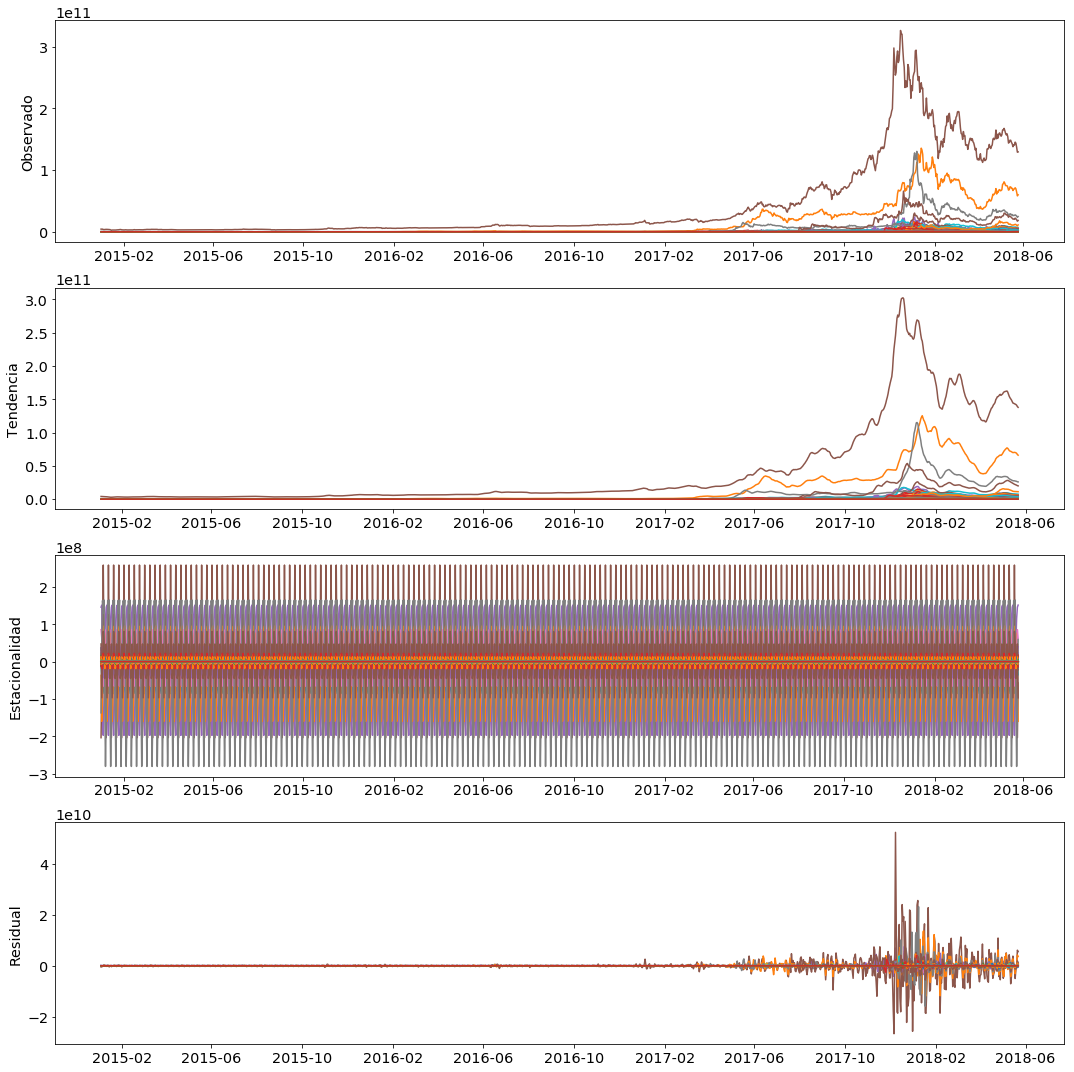

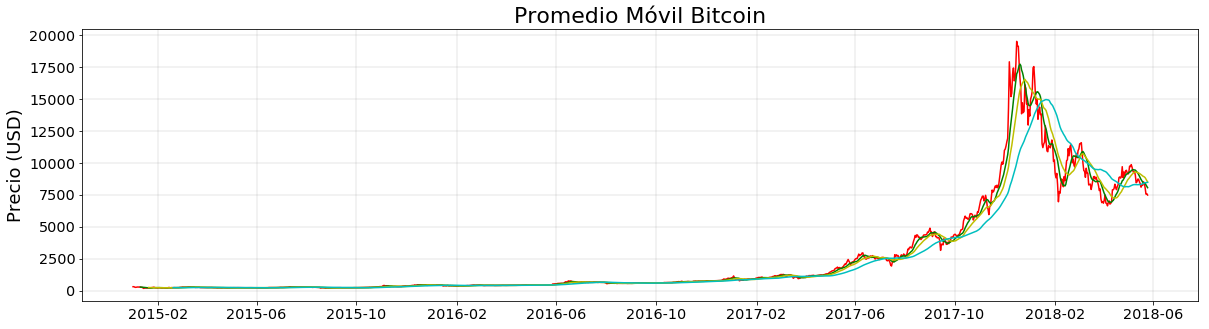

In [9]:
#Graficar la serie completa
plt.figure(figsize=(20,8))
for i in range(0,len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
plt.title("Datos",fontsize=20)
plt.show()

#Graficar precio bitcoin
plt.figure(figsize=(20,8))
plt.plot(data.index, data['Close bitcoin'], label='Precio')
plt.ylabel('Precio (USD)', fontsize=18)
plt.title("Bitcoin",fontsize=20)
plt.show()

# Descomposición de la serie en componentes 
res = sm.tsa.seasonal_decompose(data,model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,15))
axes[0].plot(res.observed);axes[0].set_ylabel('Observado')
axes[1].plot(res.trend);axes[1].set_ylabel('Tendencia')
axes[2].plot(res.seasonal);axes[2].set_ylabel('Estacionalidad')
axes[3].plot(res.resid);axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()

# Visualización del promedio móvil para 10, 20 y 50 días
promedio_movil_10 = data[['Close bitcoin']].rolling(window=10).mean()
promedio_movil_20 = data[['Close bitcoin']].rolling(window=20).mean()
promedio_movil_50 = data[['Close bitcoin']].rolling(window=50).mean()
fig = plt.figure(figsize=(20,5))
plt.plot(data[['Close bitcoin']], color = 'r', label="Precio")
plt.plot(promedio_movil_10, color='g', label="Promedio móvil (10)")
plt.plot(promedio_movil_20, color='y', label="Promedio móvil (20)")
plt.plot(promedio_movil_50, color='c', label="Promedio móvil (50)")
plt.ylabel('Precio (USD)', fontsize=18)
plt.title("Promedio Móvil Bitcoin",fontsize=22)
plt.grid(color='grey', linestyle='-', linewidth=0.2)

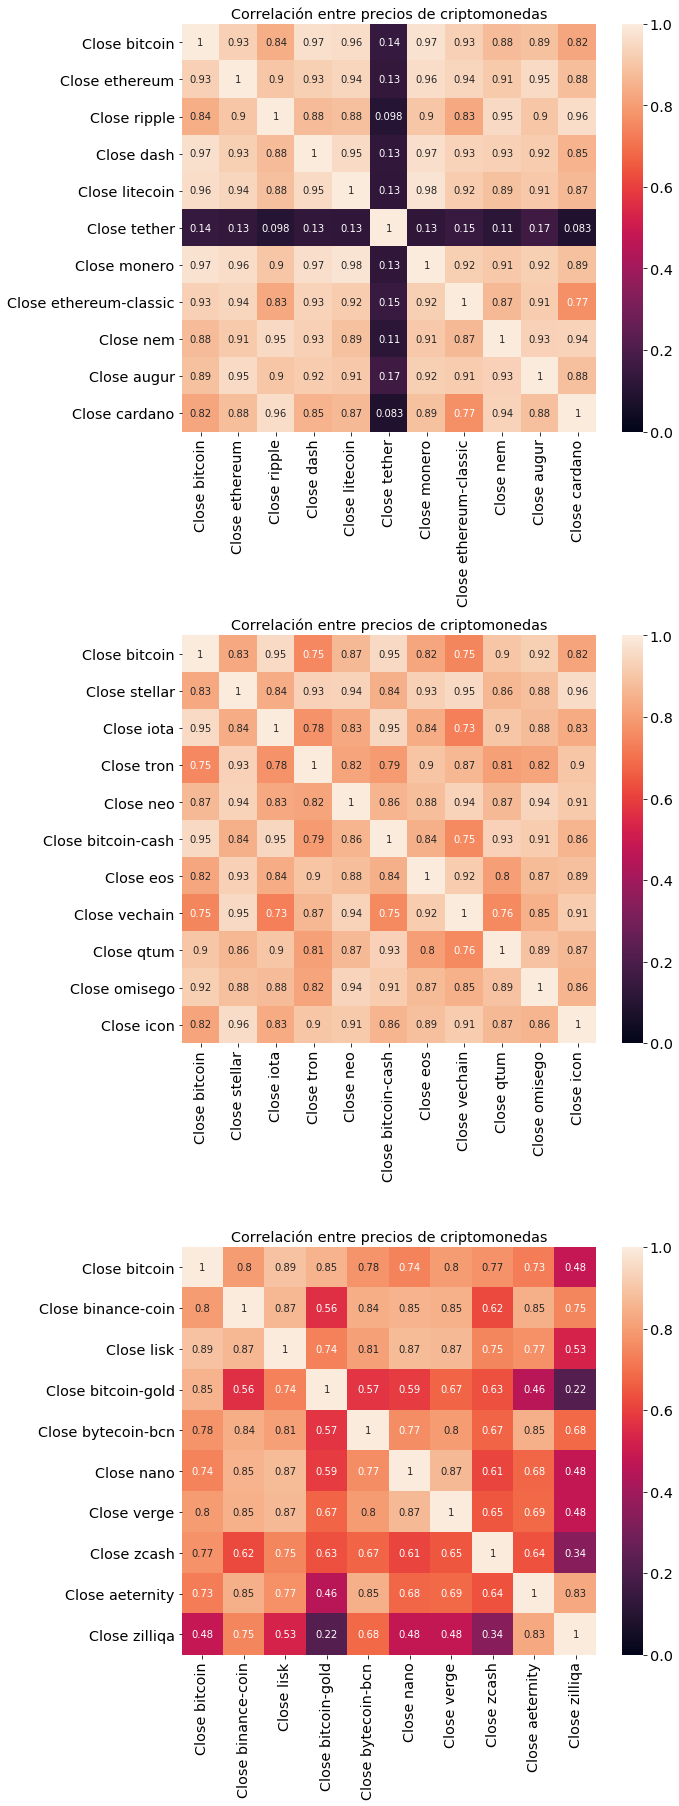

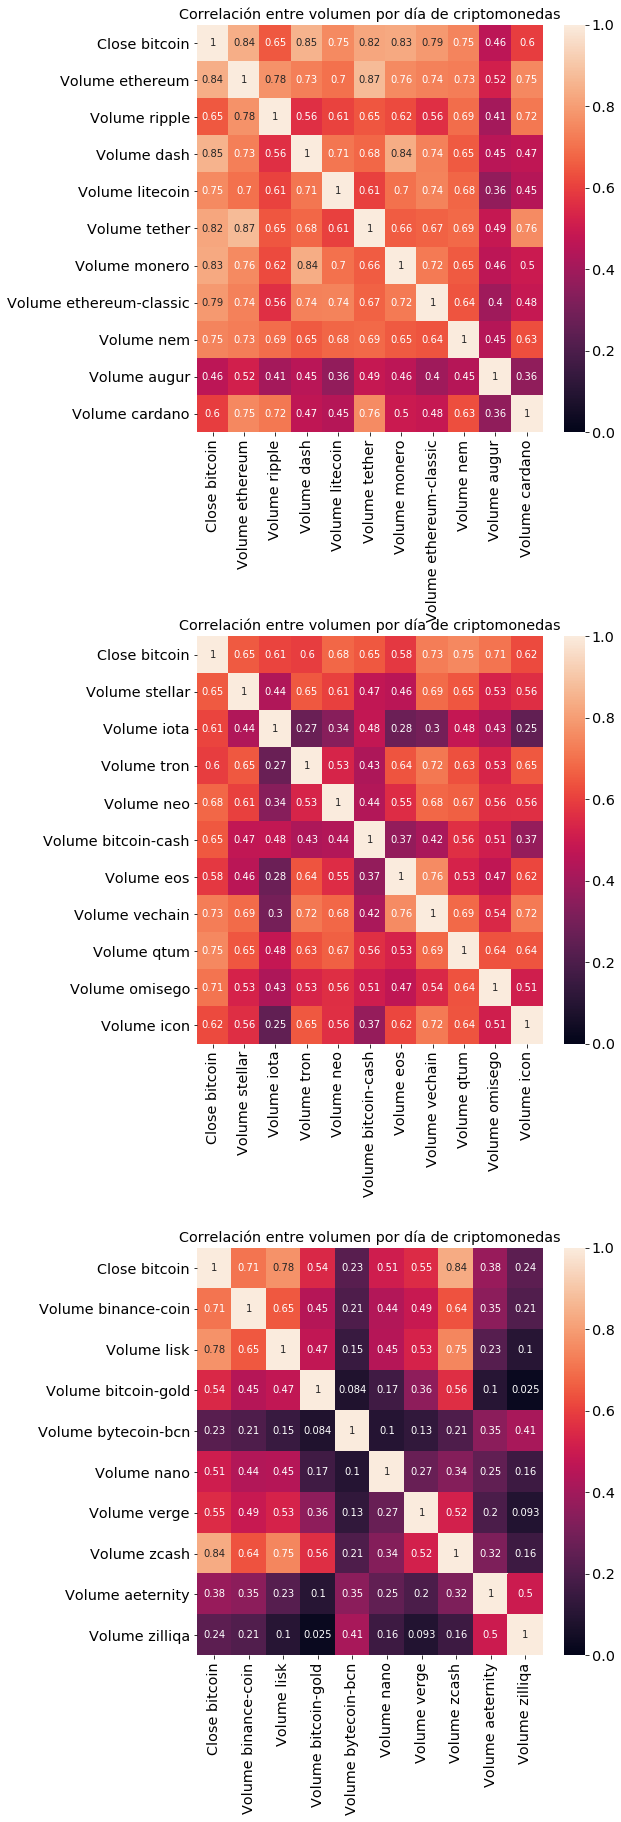

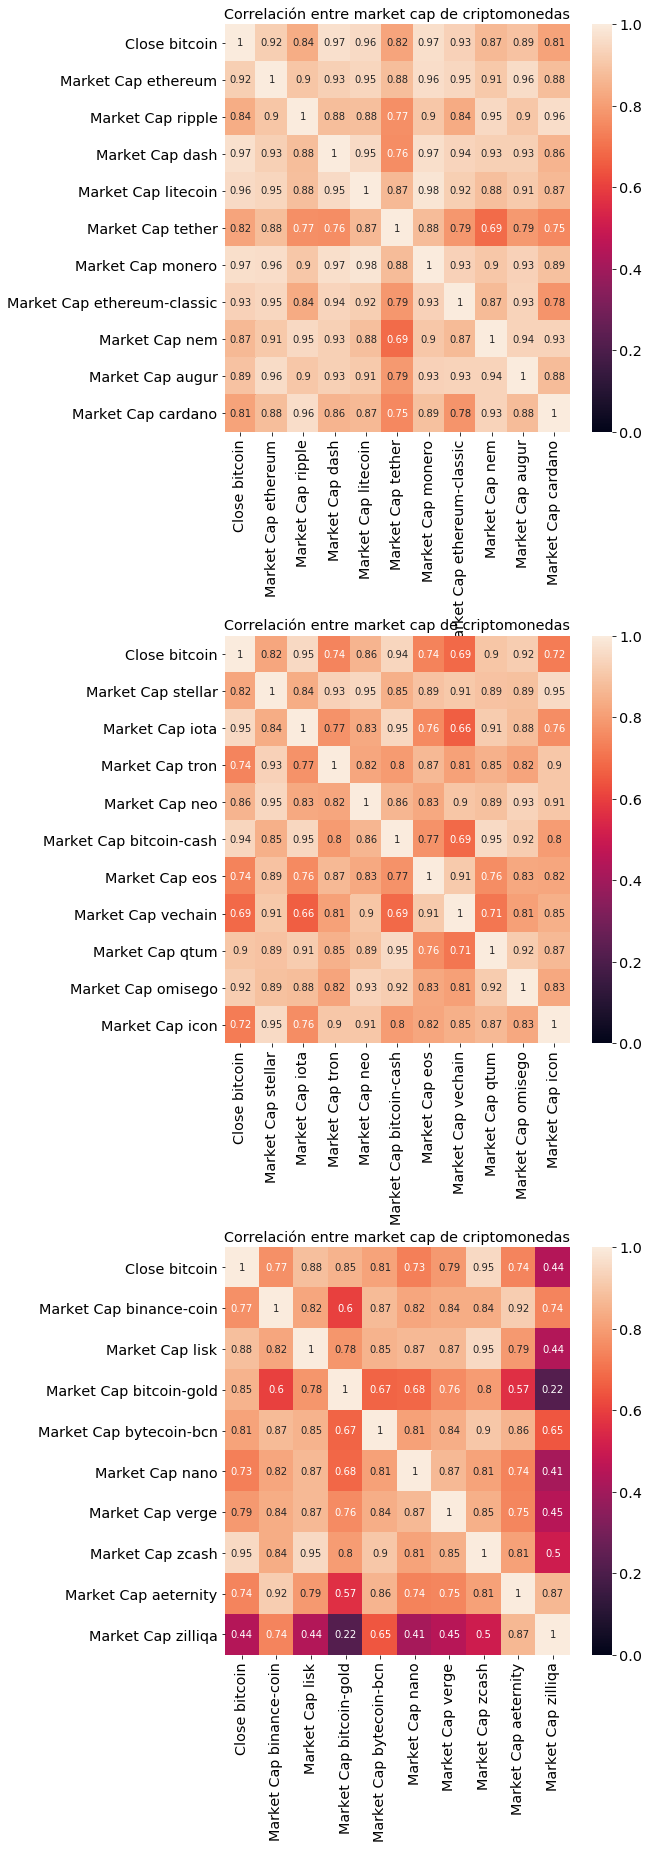

In [15]:
# Graficar correlación entre precios
fig = plt.figure(figsize=(12,10*int(len(targets_crypto)/10)))
gs = gridspec.GridSpec(int(len(targets_crypto)/10), 1, wspace=0.1, hspace=0.5); i=0
for j in range(1,len(targets_crypto),10):
    correlacion = data[['Close bitcoin'] + ['Close '+ m for m in targets_crypto[j:j+10]]].corr()
    ax = plt.subplot(gs[i])
    ax = sns.heatmap(correlacion, vmin=0, vmax=1, annot=True)
    for item in ax.get_yticklabels():
        item.set_rotation(0)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.title("Correlación entre precios de criptomonedas")
    i+=1
plt.gcf().subplots_adjust(left=0.3)
plt.savefig('data/exploracion_precios')

# Graficar correlación entre volumen
fig = plt.figure(figsize=(10,10*int(len(targets_crypto)/10)))
gs = gridspec.GridSpec(int(len(targets_crypto)/10), 1, wspace=0.3, hspace=0.5); i=0
for j in range(1,len(targets_crypto),10):
    correlacion = data[['Close bitcoin'] + ['Volume '+ m for m in targets_crypto[j:j+10]]].corr()
    ax = plt.subplot(gs[i])
    ax = sns.heatmap(correlacion, vmin=0, vmax=1, annot=True)
    for item in ax.get_yticklabels():
        item.set_rotation(0)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.title("Correlación entre volumen por día de criptomonedas")
    i+=1
plt.gcf().subplots_adjust(left=0.3)
plt.savefig('data/exploracion_volumen')

# Graficar correlación entre market cap
fig = plt.figure(figsize=(10,10*int(len(targets_crypto)/10)))
gs = gridspec.GridSpec(int(len(targets_crypto)/10), 1, wspace=0.3, hspace=0.5); i=0
for j in range(1,len(targets_crypto),10):
    correlacion = data[['Close bitcoin'] + ['Market Cap '+ m for m in targets_crypto[j:j+10]]].corr()
    ax = plt.subplot(gs[i])
    ax = sns.heatmap(correlacion, vmin=0, vmax=1, annot=True)
    for item in ax.get_yticklabels():
        item.set_rotation(0)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    plt.title("Correlación entre market cap de criptomonedas")
    i+=1
plt.gcf().subplots_adjust(left=0.3)
plt.savefig('data/exploracion_mcap')

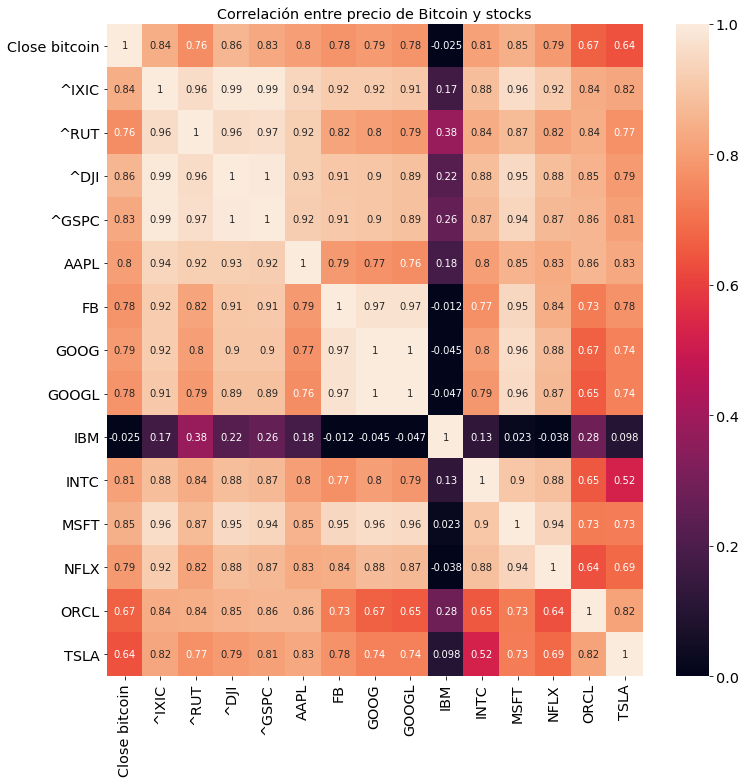

In [20]:
correlacion_stocks = data[['Close bitcoin'] + targets_stocks].corr()

# Graficar correlación entre stocks
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(correlacion_stocks, vmin=0, vmax=1, annot=True)
for item in ax.get_yticklabels():
    item.set_rotation(0)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.title("Correlación entre precio de Bitcoin y stocks")
plt.savefig('data/exploracion_stocks')
plt.show()

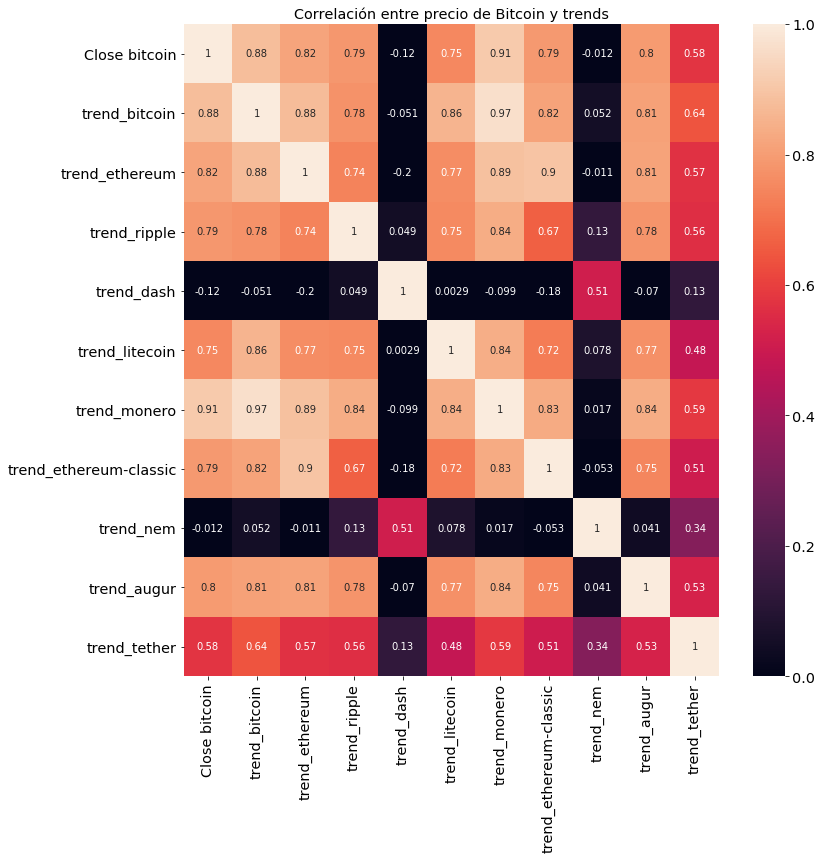

In [21]:
correlacion_stocks = data[['Close bitcoin'] + targets_trends].corr()

# Graficar correlación
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(correlacion_stocks, vmin=0, vmax=1, annot=True)
for item in ax.get_yticklabels():
    item.set_rotation(0)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.title("Correlación entre precio de Bitcoin y trends")
plt.savefig('data/exploracion_trends')
plt.show()